# 1.2 Marginal Gaussianization

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

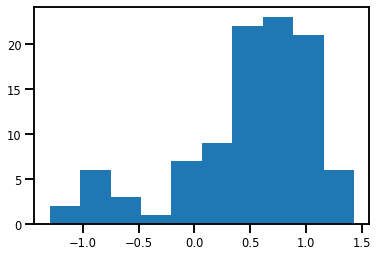

In [2]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [3]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/2p39qn1c

In [4]:

# config parameters
wandb.config.n_samples = 1_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

<Figure size 432x288 with 0 Axes>

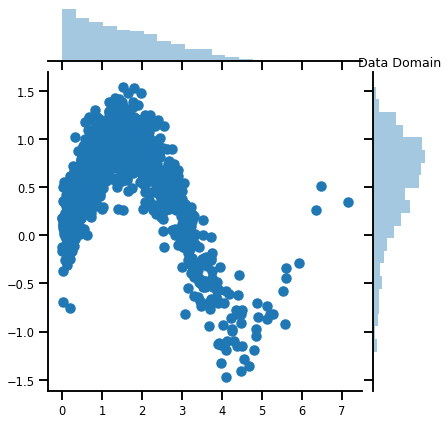

In [195]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.title('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [22]:
from rbig_jax.transforms.histogram import get_hist_params
from rbig_jax.transforms.uniformize import uniformize_transform
from rbig_jax.transforms.marginal import marginal_transform_params, marginal_transform
from rbig_jax.transforms.gaussianize import gaussianize_forward
from rbig_jax.transforms.gaussianize import gaussianize_marginal_transform, gaussianize_marginal_inverse

## Marginal Gaussianization Transformation

(aka element-wise transformation)

#### Histogram

In [23]:
# marginal Gaussianization parameters
support_extension = 10
alpha = 1e-5
precision = 1_000
nbins = int(np.sqrt(data.shape[0]))

histogram_uniformize = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

In [24]:
# define our marginal uniform transform dist
uni_transform_f = jax.partial(
        marginal_transform_params, 
        function=histogram_uniformize
    )

gaussianize_f = jax.partial(gaussianize_forward, uni_transform_f=uni_transform_f)
X_g, params = gaussianize_f(data)

<Figure size 432x288 with 0 Axes>

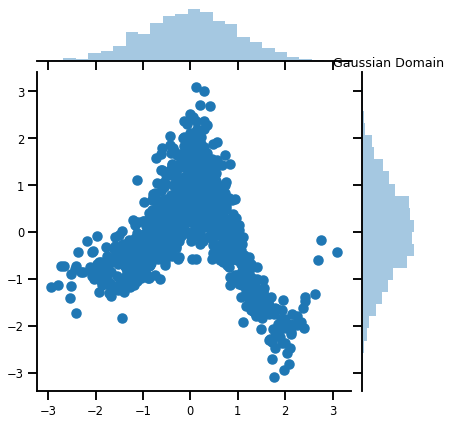

In [25]:
plt.figure()
sns.jointplot(onp.array(X_g)[:, 0], onp.array(X_g)[:, 1])
plt.title('Gaussian Domain')
plt.show()

## Rotation

In [196]:
from rbig_jax.transforms.linear import compute_projection_v1

In [212]:
X_g, _ = gaussianize_f(data)

R = compute_projection_v1(X_g)
X_r = np.dot(X_g, R)

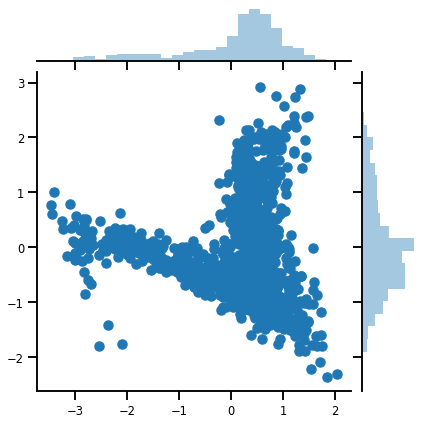

In [213]:
sns.jointplot(X_r[:, 0], X_r[:, 1])

## Marginal Gaussianization

In [207]:
from rbig_jax.transforms.rbig import rbig_block_forward, rbig_block_transform, rbig_block_inverse

In [208]:
X_r, params = rbig_block_forward(data, gaussianize_f)

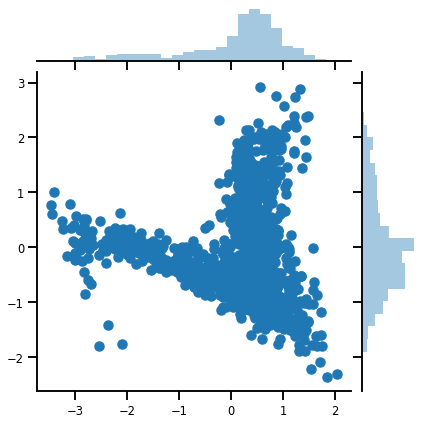

In [209]:
sns.jointplot(X_r[:, 0], X_r[:, 1])

### Forward Transform

In [214]:
from rbig_jax.transforms.gaussianize import gaussianize_marginal_transform, gaussianize_marginal_inverse
from rbig_jax.transforms.rbig import rbig_block_forward, rbig_block_transform, rbig_block_inverse

In [215]:
X_r = rbig_block_transform(data, params)

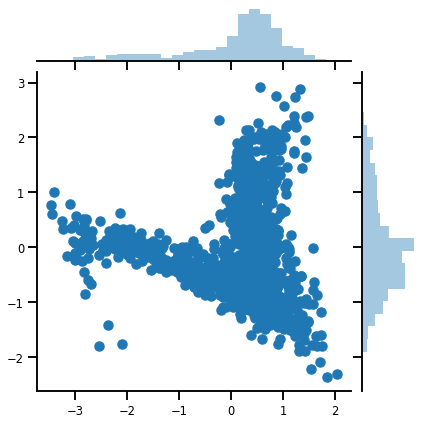

In [216]:
sns.jointplot(X_r[:, 0], X_r[:, 1])

In [217]:
X_approx = rbig_block_inverse(X_r, params)

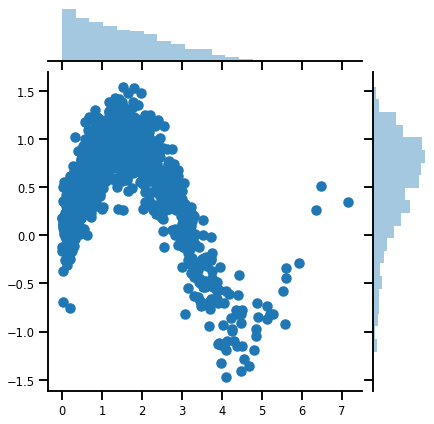

In [218]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1])

#### JIT

In [219]:
rbig_block_transform_jitted = jax.jit(rbig_block_transform)

In [220]:
rbig_block_transform_jitted(data, params)
%timeit rbig_block_transform(np.array(data).block_until_ready(), params)
%timeit rbig_block_transform_jitted(np.array(data).block_until_ready(), params)

71.6 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
459 µs ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Iterative Stopping Criteria

In [225]:
%%time

n_layers = 0
params = []

data = get_classic(10_000)
X = np.array(data)

rbig_block_jitted = jax.jit(jax.partial(rbig_block, marginal_gauss_f=gaussianize_f))



params = []

n_layers = 0

while n_layers < 50:
    
    # compute 
    X, layer_params = rbig_block_jitted(X)
    
    # increment
    n_layers += 1
    
    params.append(layer_params)
    

CPU times: user 3 s, sys: 30.2 ms, total: 3.03 s
Wall time: 2.85 s


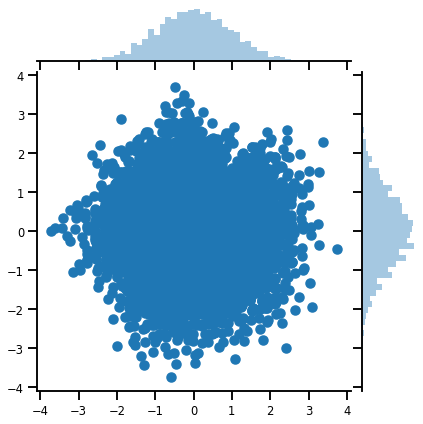

In [226]:
sns.jointplot(X[:, 0], X[:, 1])

### Forward Transformation

In [227]:
len(params)

50

In [228]:
%%time

n_layers = 1_000
layer_params = []

data_samples = get_classic(10_000)

X_trans = np.array(data_samples)

# initialize transformation
rbig_block_transform_jitted = jax.jit(rbig_block_transform)

for ilayer_param in tqdm.tqdm(params):
    X_trans = rbig_block_transform_jitted(X_trans, ilayer_param)
#     sns.jointplot(X_trans[:, 0], X_trans[:, 1])
    

100%|██████████| 50/50 [00:00<00:00, 860.97it/s]

CPU times: user 229 ms, sys: 22.3 ms, total: 252 ms
Wall time: 63.9 ms


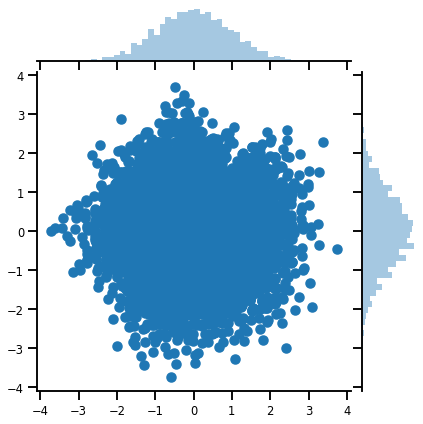

In [229]:
sns.jointplot(X_trans[:, 0], X_trans[:, 1])

### Inverse Transformation

In [230]:
%%time

n_layers = 1_000
layer_params = []

X_approx = np.array(X_trans)

# initialize transformation
rbig_block_inverse_jitted = jax.jit(rbig_block_inverse)

for ilayer_param in tqdm.tqdm(params[::-1]):
    X_approx = rbig_block_inverse_jitted(X_approx, ilayer_param)
#     sns.jointplot(X_trans[:, 0], X_trans[:, 1])

100%|██████████| 50/50 [00:00<00:00, 472.64it/s]

CPU times: user 175 ms, sys: 44.5 ms, total: 219 ms
Wall time: 109 ms


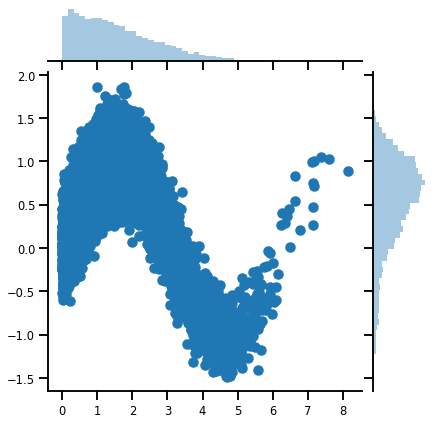

In [231]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1])